In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# two cells

In [1]:
!ls /home/spark/2017_for_Zhong/2cell_13611_13618

isoseq_flnc.fasta  preCluster.output.csv


In [19]:
def read_fasta(fname):
    lst=[]
    seq=None
    with open (fname) as f:
        for line in f:
            if line.startswith(">"):
                if seq: lst.append(seqid+"\t"+"".join(seq))
                seqid=line.split(" ")[0][1:]
                seq=[]
            else:
                seq.append(line.strip())
    if seq: lst.append(seqid+"\t"+"".join(seq))
    return lst

In [2]:
lst=read_fasta("/home/spark/2017_for_Zhong/2cell_13611_13618/isoseq_flnc.fasta")

In [3]:
len(lst)

375241

In [15]:
with open("2cell_13611_13618.seq",'w') as f:
    for i,l in enumerate(lst):
        f.write(str(i+1)+"\t"+l+"\n")

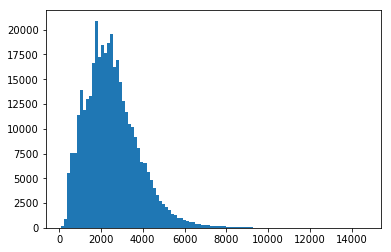

In [9]:
plt.hist([len(u) for u in lst],bins=100);

In [26]:
import pandas as pd
output=pd.read_csv("/home/spark/2017_for_Zhong/2cell_13611_13618/preCluster.output.csv")

/home/spark/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
output.shape,output[output['stat']=="chimera"].shape, output[output['stat']=="orphan"].shape

((375241, 2), (4713, 2), (24634, 2))

In [38]:
vc=output['stat'].value_counts()
vc.describe()

count    27977.000000
mean        13.412482
std        237.283716
min          1.000000
25%          2.000000
50%          3.000000
75%          9.000000
max      26358.000000
Name: stat, dtype: float64

In [51]:
vc[vc>100].head(20)

13293      26358
orphan     24634
20327       8634
13293       8426
9139        6582
chimera     4713
4011        3576
13358       2921
20327       2763
9139        2016
18157       1816
225         1758
15862       1658
13374       1366
15993       1174
4011        1151
13358        943
15956        943
16437        785
1814         684
Name: stat, dtype: int64

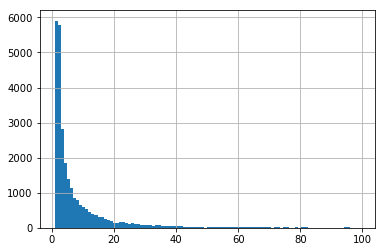

In [49]:
vc[vc<100].hist(bins=100);

In [2]:
import pandas as pd
preClusters=pd.read_csv("/home/spark/2017_for_Zhong/2cell_13611_13618//preCluster.output.csv")

/home/spark/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
preClusters.head()

,seqid,stat
0,m54006_170206_215027/39191167/4082_54_CCS,13293
1,m54086_170204_081430/54592493/1354_58_CCS,20327
2,m54086_170204_081430/63373692/1587_60_CCS,18095
3,m54006_170206_215027/24511254/1853_57_CCS,16404
4,m54006_170206_215027/22872994/31_479_CCS,15947


In [3]:
lpaClusters=pd.read_csv("../tmp/2cell_13611_13618_lpaseq.txt_31",header=None,sep="\t")
lpaClusters.columns=['seqid','stat']

In [4]:
lpaClusters.head()

,seqid,stat
0,m54086_170204_081430/27722476/30_2493_CCS,12074
1,m54086_170204_081430/45351714/31_1884_CCS,745
2,m54086_170204_081430/32047532/3383_54_CCS,892
3,m54086_170204_081430/27263553/3208_52_CCS,11079
4,m54006_170206_215027/64618994/33_4308_CCS,8411


In [71]:
a=pd.merge(preClusters,lpaClusters, on='seqid', how='left')

In [72]:
lpaClusters.shape,preClusters.shape,a.shape

((343420, 2), (375241, 2), (375241, 3))

In [73]:
a=a.fillna("-999").drop("stat_x",axis=1)
a.columns=['seqid','stat']
a.stat=a.stat.astype(np.int)
a.loc[a.stat==-999,'stat']='orphan'

In [74]:
a.shape

(375241, 2)

In [75]:
a.to_csv("../tmp/2cell_13611_13618_cluster.csv",index=None)

In [11]:
preClusters.head()

,seqid,stat
0,m54006_170206_215027/39191167/4082_54_CCS,13293
1,m54086_170204_081430/54592493/1354_58_CCS,20327
2,m54086_170204_081430/63373692/1587_60_CCS,18095
3,m54006_170206_215027/24511254/1853_57_CCS,16404
4,m54006_170206_215027/22872994/31_479_CCS,15947


In [12]:
joined=pd.merge(lpaClusters,preClusters, on='seqid')

In [13]:
joined.head()

,seqid,stat_x,stat_y
0,m54086_170204_081430/27722476/30_2493_CCS,12074,10636
1,m54086_170204_081430/45351714/31_1884_CCS,745,18714
2,m54086_170204_081430/32047532/3383_54_CCS,892,2635
3,m54086_170204_081430/27263553/3208_52_CCS,11079,5830
4,m54006_170206_215027/64618994/33_4308_CCS,8411,13293


In [14]:
joined=joined[~joined['stat_x'].isin(['chimera',"orphan"])] 

In [59]:
def calc_purity(df):
    vc=df['stat_x'].value_counts()
    return [1.0*vc.max()/df.shape[0],df.shape[0],vc.shape[0]]

In [60]:
purity=pd.DataFrame(joined[['stat_y','stat_x']].groupby('stat_y').apply(lambda u:calc_purity(u)))

In [61]:
purity['purity']=purity[0].map(lambda u: u[0])
purity['size']=purity[0].map(lambda u: u[1])
purity['n']=purity[0].map(lambda u: u[2])
purity=purity.drop(0,axis=1)

In [62]:
np.median(purity.purity),np.mean(purity.purity)

(1.0, 0.9625964430325157)

In [33]:
purity.columns=['purity','size','n']

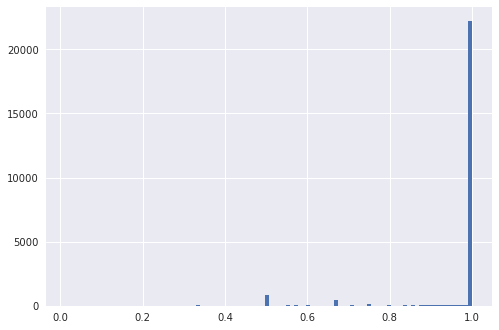

In [34]:
purity.purity.hist(bins=100);

In [35]:
import seaborn as sns
sns.set()

/home/spark/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:127: RuntimeWarning: divide by zero encountered in divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/spark/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])


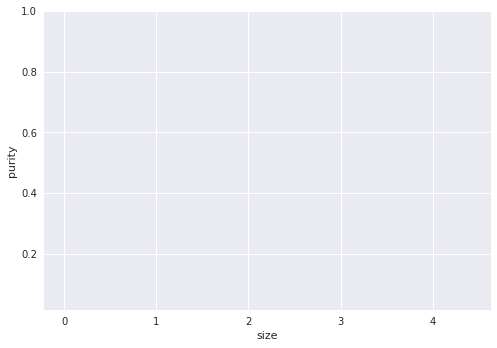

In [36]:
a=purity
sns.kdeplot(np.log10(a['size']),a.purity, n_levels=100, shade=True, shade_lowest=True)

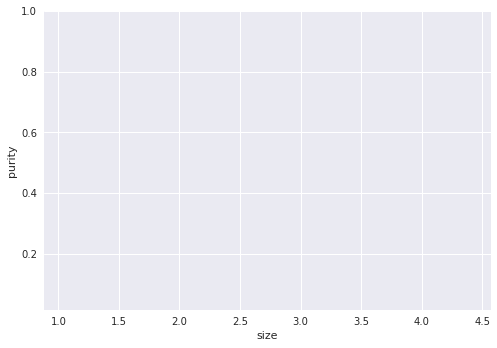

In [37]:
a=purity[purity['size']>10]
sns.kdeplot(np.log10(a['size']),a.purity, n_levels=100, shade=True, shade_lowest=True)

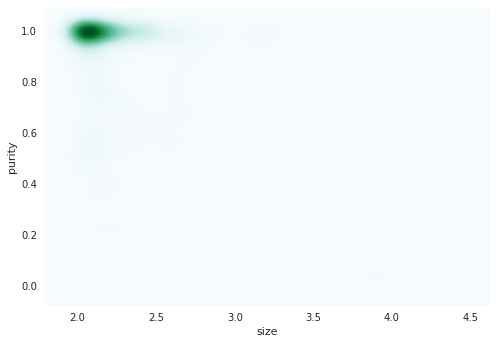

In [38]:
a=purity[purity['size']>100]
sns.kdeplot(np.log10(a['size']),a.purity, n_levels=100, shade=True, shade_lowest=True)

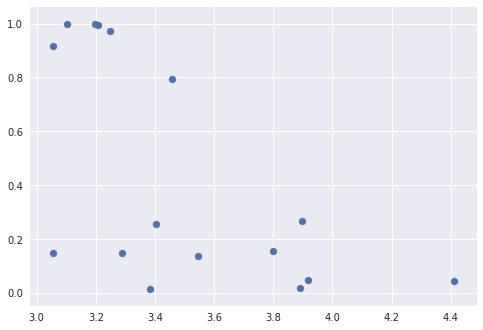

In [39]:
a=purity[purity['size']>1000]
plt.scatter(np.log10(a['size']),a.purity)

In [40]:
def calc_completeness(df):
    vc=df['stat_y'].value_counts()
    return [1.0*vc.max()/df.shape[0],df.shape[0],vc.shape[0]]

In [41]:
purity=pd.DataFrame(joined[['stat_y','stat_x']].groupby('stat_x').apply(lambda u:calc_completeness(u)))

In [42]:
purity['purity']=purity[0].map(lambda u: u[0])
purity['size']=purity[0].map(lambda u: u[1])
purity['n']=purity[0].map(lambda u: u[2])
purity=purity.drop(0,axis=1)

In [43]:
np.median(purity.purity)

0.6785714285714286

In [44]:
purity.columns=['purity','size','n']

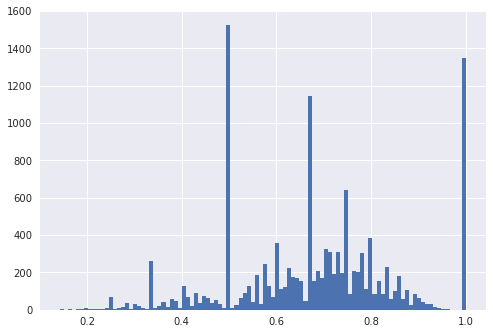

In [45]:
(purity.purity).hist(bins=100);

In [46]:
import seaborn as sns
sns.set()

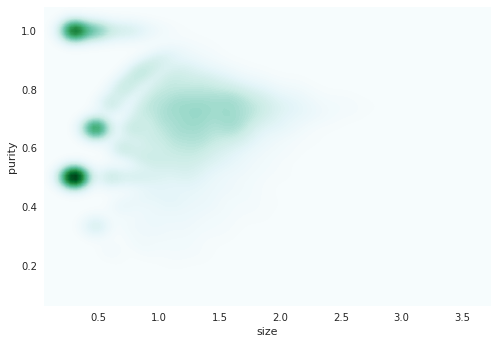

In [47]:
a=purity[purity['size']>=0]
sns.kdeplot(np.log10(a['size']),a.purity, n_levels=100, shade=True, shade_lowest=True)

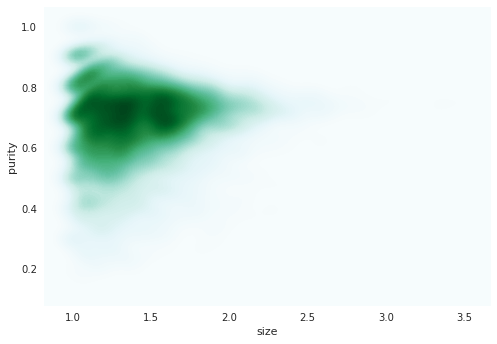

In [48]:
a=purity[purity['size']>=10]
sns.kdeplot(np.log10(a['size']),a.purity, n_levels=100, shade=True, shade_lowest=True)

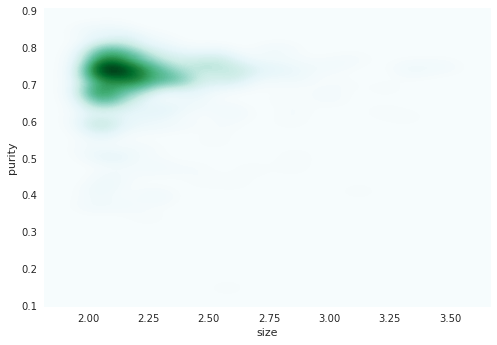

In [49]:
a=purity[purity['size']>=100]
sns.kdeplot(np.log10(a['size']),a.purity, n_levels=100, shade=True, shade_lowest=True)

(14, 3)

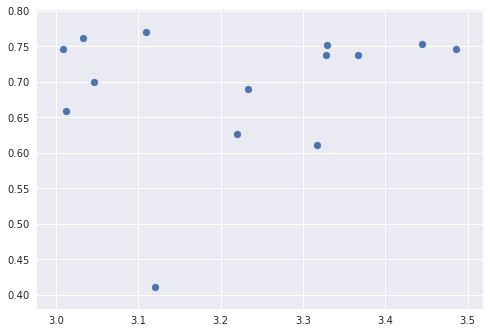

In [50]:
a=purity[purity['size']>1000]
plt.scatter(np.log10(a['size']),a.purity)
a.shape

In [51]:
purity[purity['size']>10000]

,purity,size,n
stat_x,,,


In [53]:
lpaClusters.stat.value_counts().max()

3063

In [54]:
lpaClusters.shape,preClusters.shape

((343420, 2), (375241, 2))

In [55]:
623456-585370

38086

In [57]:
preClusters['stat'].value_counts().sort_index().tail()

9995           1
9998           1
9999           1
chimera     4713
orphan     24634
Name: stat, dtype: int64